In [1]:
%matplotlib inline
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import random
import time
import math

In [3]:
def random_limit(distribution, arg1, arg2):
    
    val = distribution(arg1,arg2)
    while val > 1 or val < 0:
        val = distribution(arg1,arg2)
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            bias_val = np.random.normal(self.bias_mean,np.sqrt(1.0/self.bias_tau))
            handin.add_gradeing(self,bias_val)

class handin:
    def __init__(self,title,owner,true_value,precision):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        self.gradeings[grader.name] = random_limit(np.random.normal,self.true_val+bias,np.sqrt(1.0/self.precision))
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_gradings):
        self.n_gradings = n_gradings
        # Distribute handins
        for i in xrange(0,n_gradings):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(grader)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()
            
class Course(object):
    
    def __init__(self):
        self.assignments = list()
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = 0
    
    def add_assignment(self,assignment):
        self.assignments.append(assignment)
        for a in self.assignments:
            self.handins.update(a.handins)
            self.graders.update(a.graders)
        self.n_gradings = self.n_gradings + a.n_gradings

In [4]:
course = Course()

handins_data = list()
graders_data = list()

for i in xrange(0,60):
    mu = np.random.normal(0.0,np.sqrt(1.0/100.0))
    tau = np.random.gamma(50.0,1.0/0.1)
    g = grader('%i' % i,mu,tau)
    graders_data.append(g)
for i in xrange(0,60):
    t_mu = random_limit(np.random.normal,0.5,np.sqrt(1.0/25.0))
    t_tau = np.random.gamma(10,np.sqrt(1.0/0.1))
    h = handin('%i' % i, graders_data[i], t_mu, t_tau)
    handins_data.append(h)
    
assignment_data = assignment(handins_data,graders_data)
assignment_data.grade_handins(5)
course.add_assignment(assignment_data)

In [5]:
handins_data = list()

for i in xrange(60,120):
    t_mu = random_limit(np.random.normal,0.5,np.sqrt(1.0/25.0))
    t_tau = np.random.gamma(10,np.sqrt(1.0/0.1))
    h = handin('%i' % i, graders_data[i-60], t_mu, t_tau)
    handins_data.append(h)
    
assignment_data_2 = assignment(handins_data,graders_data)
assignment_data_2.grade_handins(5)
course.add_assignment(assignment_data_2)

In [6]:
handins_data = list()

for i in xrange(120,180):
    t_mu = random_limit(np.random.normal,0.5,np.sqrt(1.0/25.0))
    t_tau = np.random.gamma(10,np.sqrt(1.0/0.1))
    h = handin('%i' % i, graders_data[i-120], t_mu, t_tau)
    handins_data.append(h)
    
assignment_data_3 = assignment(handins_data,graders_data)
assignment_data_3.grade_handins(5)
course.add_assignment(assignment_data_3)

## Gibbs Implementation

In [18]:
def gibbs_model(data):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    e = np.random.gamma(al_e,1.0/be_e)
    for h in range(N_H):
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_g * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in range(N_G):
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))

    # Gibbs sampling
    
    burn_in = 1000  # warm-up steps
    samples = 5000 # Gibbs sampling steps
    
    # Tracers initialising
    trace_e = list()
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    trace_T = defaultdict(list)
    trace_B = defaultdict(list)
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h in range(N_H):
            handin = data.handins[str(h)]
            n_gradings = len(handin.graders)
            sum_ = 0.0
            for g, val in handin.gradeings.iteritems():
                sum_ = sum_ + val - B[int(g)]
            v = e*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+e*sum_)/v,np.sqrt(1/v))
            
        # Sample B
        for g in range(N_G):
            grader = data.graders[str(g)]
            n_gradings = len(grader.handins)
            sum_ = 0.0
            for h in grader.handins:
                sum_ = sum_ + h.gradeings[str(g)] - T[int(h.title)]
            v = e*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+e*sum_)/v,np.sqrt(1/v))
        
        # Sample e
        sum_ = 0.0
        for h in range(N_H):
            for g, grading in data.handins[str(h)].gradeings.iteritems():
                sum_ = sum_ + np.square(grading - (T[int(h)]+B[int(g)]))
        e = np.random.gamma(al_e+0.5*N_eval,1.0/(be_e+0.5*sum_))

        # Sample u_h and t_h
        for h in range(N_H):
            la_ = (la_h+1.0)
            al_ = al_h + 0.5 * la_h + 0.5 * np.square(T[h]-u_h[h])
            be_ = be_h + 0.5 + 0.5 * 1.0
#            al_ = al_h+0.5
#            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in range(N_G):
            la_ = (la_g+1)
            al_ = al_g + 0.5 * la_g + 0.5 * np.square(B[g]-u_g[g])
            be_ = be_g + 0.5 + 0.5 * 1
#            al_ = al_g+0.5
#            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0/(t_g[g])))
            
        # Collect tracings
        if r > burn_in:
            trace_e.append(e)
            for h in range(N_H):
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
                trace_T[h].append(T[h])
            for g in range(N_G):
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                trace_B[g].append(B[g])
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'e' : trace_e,
              'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g,
              'T' : trace_T,
              'B' : trace_B}

    return traces

In [19]:
traces = gibbs_model(course)

6000 out of 6000
Wall time: 156.717040


## Metropolish Hasting

In [9]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

In [10]:
def MH_model(data):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g, val in handin.gradeings.iteritems():
            sum_ = sum_ + norm_log_pdf(val,u_g[int(g)]+u_h,t_g[int(g)]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.gradeings[str(g)]
            sum_ = sum_ + norm_log_pdf(val,u_g+u_h[int(h.title)],t_g+t_h[int(h.title)])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in range(N_H):
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in range(N_G):
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
    for h in range(N_H):
        handin = data.handins[str(h)]
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g in range(N_G):
        grader = data.graders[str(g)]
        log_g[g] =prop_u_t_g(grader,g,u_g[g],t_g[g])
        
    # Gibbs sampling
    
    burn_in = 4000  # warm-up steps
    samples = 8000 # Gibbs sampling steps    
    
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    ## Acception ratior
    accepted_h = 0.0
    accepted_g = 0.0

    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h in range(N_H):
            handin = data.handins[str(h)]
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                accepted_h = accepted_h+1.0
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g in range(N_G):
            grader = data.graders[str(g)]
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                accepted_g = accepted_g + 1.0
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in range(N_H):
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in range(N_G):
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [11]:
traces_MH = MH_model(course)

12000 out of 12000
Wall time: 532.656344


### Data Plot

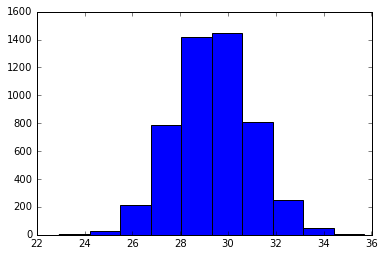

In [20]:
plt.hist(traces['e'])
plt.show()

In [21]:
def plot_scores(scores):
    ax = plt.subplot(111)
    
    scores.sort(key=lambda x:x[1])
    print "Gibbs MSE:" ,
    print sum(map(lambda x : (float(x[2]) - float(x[1])) ** 2,scores)) / len(scores)
    print "MH MSE:" ,
    print sum(map(lambda x : (float(x[3]) - float(x[1])) ** 2,scores)) / len(scores)
    model_1 = map(lambda x : float(x[2]),scores)
    model_2 = map(lambda x : float(x[3]),scores)

    true = map(lambda x : float(x[1]),scores)
    label = map(lambda x : float(x[0]),scores)
    y = xrange(0,len(scores))
    if len(scores[0]) > 4:
        print "Mean MSE:" ,
        print sum(map(lambda x : (float(x[4]) - float(x[1])) ** 2,scores)) / len(scores)
        mean = map(lambda x : float(x[4]),scores)
        plt.plot(mean,y,'+m',label="Mean",alpha=0.8)
    plt.plot(model_1,y,'or',label="Gibbs sampling",alpha=0.65)
    plt.plot(model_2,y,'og',label="MH sampling",alpha=0.65)
    plt.plot(true,y,'.b',label="True score")
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*3])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)

Gibbs MSE: 0.00368894933014
MH MSE: 0.00308213664317


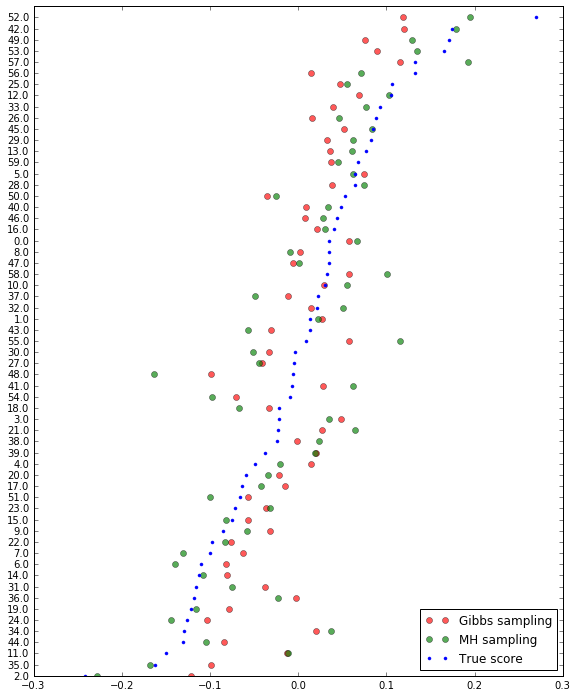

In [22]:
scores = list()
for name, g in course.graders.iteritems():
    scores.append((name,float(g.bias_mean),np.mean(traces['B'][int(name)]),np.mean(traces_MH['u_g'][int(name)])))
plot_scores(scores)

Gibbs MSE: 0.00924618287836
MH MSE: 0.00851184272625
Mean MSE: 0.00957933965145


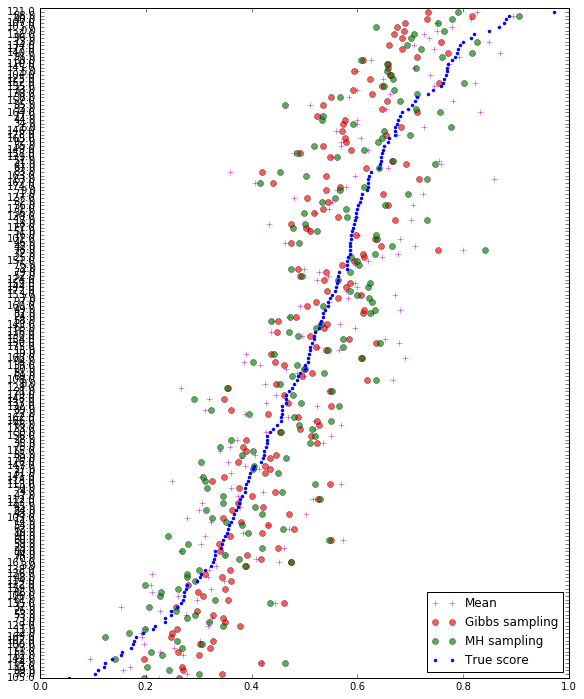

In [23]:
scores = list()
for title, h in course.handins.iteritems():
    mean = np.mean(h.gradeings.values())
    scores.append((title,float(h.true_val),np.mean(traces['T'][int(title)]),np.mean(traces_MH['u_h'][int(title)]),mean))
plot_scores(scores)

Gibbs MSE: 206513.668947
MH MSE: 11394.7609055


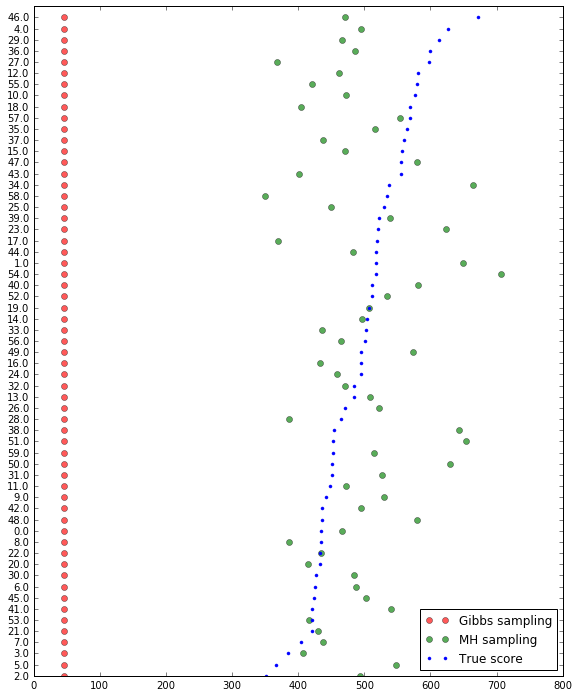

In [16]:
scores = list()
for name, g in course.graders.iteritems():
    scores.append((name,float(g.bias_tau),np.mean(traces['t_g'][int(name)]),np.mean(traces_MH['t_g'][int(name)])))
plot_scores(scores)

Gibbs MSE: 566.376890376
MH MSE: 5859.71402548


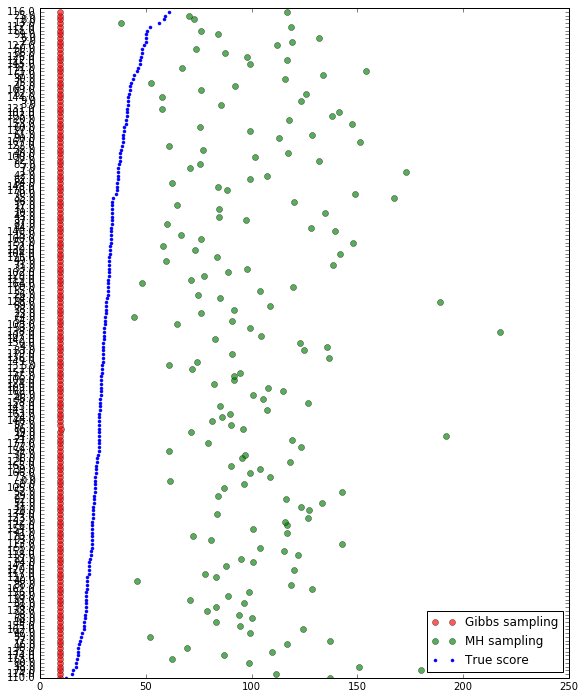

In [17]:
scores = list()
for title, h in course.handins.iteritems():
    scores.append((title,float(h.precision),np.mean(traces['t_h'][int(title)]),np.mean(traces_MH['t_h'][int(title)])))

plot_scores(scores)

# Gibbs VS Metropolish-Hastings

In [ ]:
data = [('1 ass, 5 gradings',(1,5),
            [(10,(12.790668,57.900565),(0.00396215658112,0.00343636958957),(0.00272705178409,0.0027463744647,0.00311128037185)),
            (25,(32.284305,140.570326),(0.00285561143077,0.00395592125052),(0.00250728724234,0.00352538186455,0.00384835208263)),
            (50,(68.285382,281.178547),(0.00383541887605,0.00372771252952),(0.00459256753135,0.00427013361387,0.00616191163581)),
            (75,(91.985414,447.503698),(0.00280533557864,0.0025986408138),(0.00266882995201,0.00276971297747,0.00306393157206)),
            (100,(129.621921,558.601702),(0.00251112666561,0.00250678034188),(0.00228008582889,0.00265241005475,0.0033907274497))]),
        ('2 ass, 5 gradings',(2,5),
            [(10,(21.751322,101.280998),(0.000599552194611,0.000519534729924),(0.00223887189899,0.00231166016777,0.00319358329857)),
            (25,(54.091325,258.348642),(0.00170217767175,0.00305809066191),(0.0030161347189,0.00398030763048,0.00370361188839)),
            (50,(105.476111,515.320637),(0.00258637781625,0.00222773010294),(0.00316105874037,0.0028240074092,0.00472583524955)),
            (75,(166.690170,776.501201),(0.00157667919136,0.00161864476224),(0.00294835315311,0.00315895305577,0.00379260791628)),
            (100,(221.209965,1028.303392),(0.00257505035508,0.00300899111693),(0.00312691537836,0.00329034855292,0.00424165249886))]),
        ('3 ass, 5 gradings',(3,5),
            [(10,(31.666683,148.298801),(0.000817218588415,0.000902813203429),(0.00284995882368,0.00295207814728,0.00323563855712)),
            (25,(76.958194,367.428722),(0.00135636362453,0.0015005991747),(0.00240201542534,0.00245042571276,0.00313310956358)),
            (50,(153.502610,675.222766),(0.00154867821043,0.00161655637221),(0.00316103554345,0.00348670731758,0.00468350612372)),
            (75,(214.330730,997.277463),(0.00133214750441,0.00147556230014),(0.00312192644253,0.00316746212354,0.00371006421091)),
            (100,(291.216917,1386.321223),(0.0013597008557,0.0016001974907),(0.00387072790262,0.00375904903641,0.00531846003212))]),
        ('1 ass, 10 gradings',(1,10),
            [(11,(23.696377,116.236462),(0.000854223492284,0.00105032433118),(0.00174331349455,0.00190213670446,0.0019612604557)),
            (25,(40.671939,242.797992),(0.00133070544603,0.00207421174465),(0.00195038199833,0.00273662005329,0.00224812366911)),
            (50,(96.136426,428.017783),(0.00183605346996,0.00220988137931),(0.00165732530891,0.00218663003312,0.0031741958337)),
            (75,(123.505629,639.077949),(0.00177382572923,0.00148734178691),(0.00165793215611,0.00171991355932,0.0025868150629)),
            (100,(190.602098,945.197916),(0.00174598893287,0.00176112885776),(0.00232035214017,0.0023662505256,0.00190475691097))])]

Execution time of the two models

In [ ]:
for i, (name,(ass,gradings),values) in enumerate(data):
    index = list()
    time_1 = list()
    time_2 = list()

    for (graders, (t_1,t_2), (M_1,M_2),(N_1,N_2,N_3)) in values:
        index.append(graders)
        time_1.append(t_1)
        time_2.append(t_2)
        
    ax = plt.subplot(1,1,1) 
    
    plt.plot(index,time_1,'r',label="Gibbs")
    plt.plot(index,time_2,'b',label="MH")
    
    plt.title(name + ": Time")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("seconds")
    plt.xlabel("graders")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height])
    plt.show()

We can see that both models increases linear with the amount of total evaluation.
So when a new assignment is added the running time is almost doubled

It is clear that Gibbs is far superio in the running time

Next I plot of the found Mean Sqaure error of the bias of the graders

In [ ]:
for i, (name,(ass,gradings),values) in enumerate(data):
    index = list()
    MSE_b_1 = list()
    MSE_b_2 = list()

    for (graders, (t_1,t_2), (M_1,M_2),(N_1,N_2,N_3)) in values:
        index.append(graders)
        MSE_b_1.append(M_1)
        MSE_b_2.append(M_2)
        
    ax = plt.subplot(1,1,1) 
    
    plt.plot(index,MSE_b_1,'r',label="Gibbs")
    plt.plot(index,MSE_b_2,'b',label="MH")
    
    plt.title(name + ": Bias error")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("seconds")
    plt.xlabel("graders")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height])
    plt.show()

Here it is not apparent which of the models are better but in general it seems that Gibbs is a bit better.
For both model the error increases in most of the cases when more graders are present. However it is only when it goes from 10 to 20 graders and from there the error does not increase with more graders.

Most promient detail is the the model is better at finding the bias as the number of assignment or gradings increases. The one with most effect increasing he gradings

Next i plot the mean square error of the true score of a handin

In [ ]:
for i, (name,(ass,gradings),values) in enumerate(data):
    index = list()
    MSE_t_1 = list()
    MSE_t_2 = list()
    MSE_t_3 = list()

    for (graders, (t_1,t_2), (M_1,M_2),(N_1,N_2,N_3)) in values:
        index.append(graders)
        MSE_t_1.append(N_1)
        MSE_t_2.append(N_2)
        MSE_t_3.append(N_3)
        
    ax = plt.subplot(1,1,1) 
    
    plt.plot(index,MSE_t_1,'r',label="Gibbs")
    plt.plot(index,MSE_t_2,'b',label="MH")
    plt.plot(index,MSE_t_3,'g',label="Mean")
    
    plt.title(name + ": True score error")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("seconds")
    plt.xlabel("graders")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height])
    plt.show()

Here there are no trends as the number of assignments or graders increases. However we do see that the model at times does follow the Mean value the observed data.

We can see that the error for both model and mean is less when there are more gradings present. But this should be expected as there are more observation of each handin

### summary

- Gibbs is far superior than MH in running time.
- The precision of the found bias of the graders increases as the number of assignment or gradings is increased but is reduced when more graders are present to a max value of around 25 graders
- The true score of an assignment does not improve as the number of assignments og graders increases. But does increases as the number of handins are increased